# EMIT L2A Reflectance – end‑to‑end example
This notebook follows the same **flow** as your original: setup → search → pick → download → open/flatten → mask → (optional) orthorectify → visualize → (optional) export/merge.

It uses the refactored helpers in `emitref/` plus your original `emit_tools` (vendored in the package).

## 1) Environment & imports

In [1]:
! pip install -r requirements.txt

In [2]:
# If you unzipped the package next to this notebook, ensure Python can import it.
# Adjust the path below if needed.
import sys, pathlib
p = pathlib.Path().resolve()
# Example: sys.path.append(str(p / "emitref_refactor_with_emit_tools"))
# If you've installed as a package (pip -e .), you can skip sys.path fiddling.

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# interactive (optional)
import hvplot.xarray  # noqa: F401
import holoviews as hv
hv.extension('bokeh')

from datetime import datetime, timezone, timedelta

# Our helpers
from EMIT_data.EMIT_utils import (
login, search, choose_nearest, download_reflectance,
open_reflectance, attach_wavelengths
)
from EMIT_data.geo import get_pixel_center_coords, apply_glt, ortho_xr
from EMIT_data.emit_tools import (
    quality_mask, band_mask,
    spatial_subset,
    ortho_xr 
)


In [3]:
LAT = 50.3794
LON = 45.1656
DATE = "2024-06-04"
DAYS_BEFORE = 5
DAYS_AFTER  = 5
SEARCH_BUFFER_M = 5000   

target_dt = datetime(2024, 6, 4, tzinfo=timezone.utc)  # center date
start = target_dt - timedelta(days=DAYS_BEFORE)
end   = target_dt + timedelta(days=DAYS_AFTER)

print(start, "→", end)


2024-05-30 00:00:00+00:00 → 2024-06-09 00:00:00+00:00


In [4]:
# This opens a browser/device-code flow on first run and caches your token (persist=True)
login(persist=True)


## 4) Search EMIT L2A reflectance and pick nearest granule

In [5]:
from s2_data.s2_utils import point_buffer_bbox

In [6]:
ROI = point_buffer_bbox(LON, LAT, SEARCH_BUFFER_M)
ROI_BBOX = ROI.bounds

In [7]:
picks = search(point=(LON, LAT), bbox = ROI_BBOX, buffer_m=SEARCH_BUFFER_M, start=None, end=None, cloud_cover = (0.0,100.0))

Found 28 granule(s).


In [8]:
picks = search(point=(LON, LAT), bbox = ROI_BBOX, buffer_m=SEARCH_BUFFER_M, start=None, end=None, cloud_cover = (0.0,1.0))

Found 2 granule(s).


In [9]:
picks[0]["umm"]["CloudCover"]

1

In [10]:
picks[0].keys()

dict_keys(['meta', 'umm', 'size'])

In [11]:
picks[0]["umm"]["ProviderDates"][0]["Date"]

'2024-04-24T20:58:56Z'

In [12]:
pick = choose_nearest(picks, target_dt)
if pick is None:
    raise SystemExit("No EMIT granules found in the window.")
pick

Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 43.92085647583008, 'Latitude': 50.66027069091797}, {'Longitude': 43.78695297241211, 'Latitude': 49.920875549316406}, {'Longitude': 44.97908401489258, 'Latitude': 49.704986572265625}, {'Longitude': 45.11298751831055, 'Latitude': 50.44438171386719}, {'Longitude': 43.92085647583008, 'Latitude': 50.66027069091797}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-04-17T07:44:44Z', 'EndingDateTime': '2024-04-17T07:44:56Z'}}
Size(MB): 3579.5295419692993
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240417T074444_2410805_001/EMIT_L2A_RFL_001_20240417T074444_2410805_001.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240417T074444_2410805_001/EMIT_L2A_RFLUNCERT_001_20240417T074444_2410805_001.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240417T074444_2410805_001/EMIT_L2A_MASK_001_20240417T074444_2410805_001.nc']

## 5) Download reflectance (NetCDF)

In [13]:
from pathlib import Path
out_dir = Path("data/emit")
paths = download_reflectance(pick, out_dir, assets=['_RFL_'])
paths

Filtered to 1 reflectance-related asset link(s).


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[PosixPath('data/emit/EMIT_L2A_RFL_001_20240417T074444_2410805_001.nc')]

In [14]:
ds = open_reflectance(paths[0], engine='h5netcdf')      
ds = attach_wavelengths(ds)           
ds


<xarray.Dataset> Size: 2GB
Dimensions:      (downtrack: 1280, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    reflectance  (downtrack, crosstrack, bands) float32 2GB ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             49.72239835339113
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 4.37866265e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...

In [15]:
mask_paths = download_reflectance(pick, out_dir, assets=['_MASK_'])

Filtered to 1 reflectance-related asset link(s).


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
from EMIT_data.emit_tools import emit_xarray

In [17]:
qmask = quality_mask(mask_paths[0], quality_bands=[0,1,2,3,4])
bmask = band_mask(mask_paths[0])  

ds_emit = emit_xarray(paths[0], ortho=True, engine="netcdf4")

Flags used: ['Cloud flag' 'Cirrus flag' 'Water flag' 'Spacecraft Flag'
 'Dilated Cloud Flag']


In [18]:
ds_emit['wavelengths'].values.shape

(285,)

In [19]:
ds_vis = ds_emit


In [20]:
rfl_var = "reflectance" if "reflectance" in ds_vis.data_vars else list(ds_vis.data_vars)[0]
ds_vis[rfl_var].dims

('latitude', 'longitude', 'wavelengths')

In [21]:
from EMIT_data.viz import emit_quicklook_matplotlib

In [22]:
import hvplot.xarray
import jupyter_bokeh
import holoviews as hv, panel as pn
pn.extension(comms='colab')
hv.extension('bokeh')

In [23]:
import os

In [24]:
# !pip install brain_pipe

In [25]:
# !pip uninstall -y hytools

In [26]:
# !pip install hy-tools-lite

In [27]:
# !pip install "git+https://github.com/EnSpec/hytools.git"

In [28]:
from EMIT_data.emit_proj import nc_to_envi

In [29]:
emit_rfl_nc = paths[0]      # or EMIT L1B radiance
emit_obs_nc = mask_paths[0]    # optional
s2_tif_path = "data/s2/S2A_37UGR_20230417_0_L2A_visual.tif"       # your Sentinel-2 GeoTIFF
out_dir      = "emit_out"             # or any writable folder
tmp_dir      = "emit_tmp"
os.makedirs(out_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)

# Run: match CRS to S2, keep EMIT at 60 m (set match_res=True to copy S2 pixel size)
nc_to_envi(
    img_file=emit_rfl_nc,
    out_dir=out_dir,
    temp_dir=tmp_dir,
    obs_file=emit_obs_nc,     # or None
    export_loc=True,          # also produce *_LOC
    crid="000",
    s2_tif_path=s2_tif_path,  # copy CRS from S2
    match_res=False,          # True → resample to S2 pixel size
    write_xml=False            # write XML sidecars
)

Opened EMIT image dataset: data/emit/EMIT_L2A_RFL_001_20240417T074444_2410805_001.nc
Disabling auto mask/scale for variable 'reflectance'
Exporting EMIT L2A_RFL dataset
Projecting data to EPSG:32637 (60 m)
Creating output file that is 1702P x 1821L.
Using internal nodata values (e.g. -9999) for image emit_tmp/data_gcs.
Copying nodata values from source emit_tmp/data_gcs to destination emit_out/SISTER_EMIT_L2A_RFL_20240417T074444_000.bin.
Processing emit_tmp/data_gcs [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Exporting EMIT location dataset
Projecting location datacube to EPSG:32637 (60 m)
Creating output file that is 1702P x 1821L.
Using internal nodata values (e.g. -9999) for image emit_tmp/loc_gcs.
Copying nodata values from source emit_tmp/loc_gcs to destination emit_out/SISTER_EMIT_L2A_RFL_20240417T074444_000_LOC.bin.
Processing emit_tmp/loc_gcs [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Exporting EMIT observation dataset
Projecti

In [30]:
from EMIT_data.viz import show_emit_rgb_from_envi

Reading: SISTER_EMIT_L2A_RFL_20240417T074444_000.bin
Picked band 33 at 626.4 nm for target 630.0 nm
Picked band 20 at 529.5 nm for target 532.0 nm
Picked band 11 at 462.6 nm for target 465.0 nm


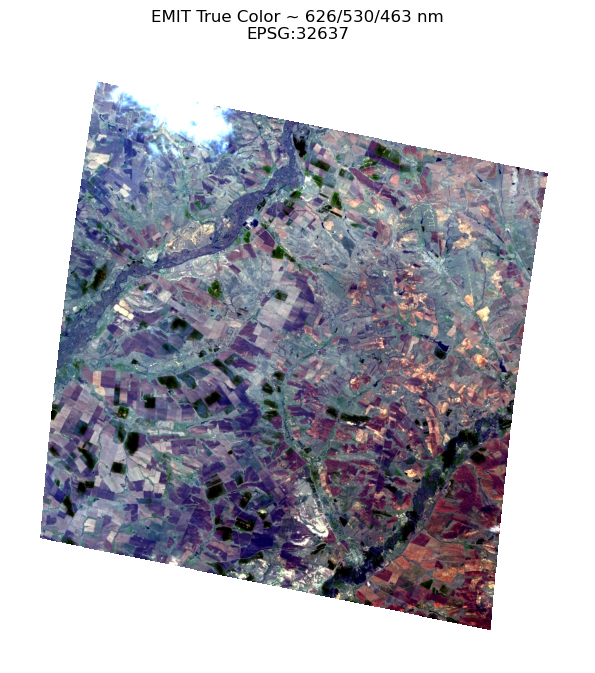

In [39]:
out_dir = "emit_out"
show_emit_rgb_from_envi(out_dir, gamma = 1.0, pattern = "SISTER_EMIT_L2A_RFL_20240417T074444_000.bin", white_balance=False)

<Axes: title={'center': 'EMIT True Color ~ 664/559/492 nm'}>

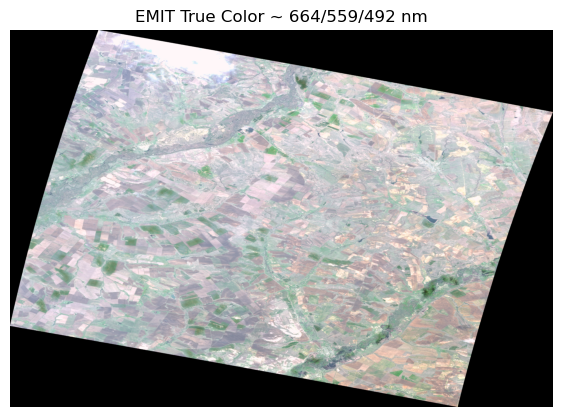

In [36]:
emit_quicklook_matplotlib(ds_vis, white_balance=True, gamma = 1)